Loading standard structure from: ./standard_/Si_POSCAR
SOAP descriptor initialized and standard vector calculated.
Scanning ./16 atoms calculation/plot for *_POSCAR files...
ID 1: 1_0_POSCAR_mattersim_opt | E: 0.3490 eV | Dist: 0.0144
ID 2: 1_10_POSCAR_mattersim_opt | E: 0.2922 eV | Dist: 0.0153
ID 3: 1_11_POSCAR_mattersim_opt | E: 0.4211 eV | Dist: 0.0044
ID 4: 1_12_POSCAR_mattersim_opt | E: 0.2922 eV | Dist: 0.0089
ID 5: 1_13_POSCAR_mattersim_opt | E: 0.3575 eV | Dist: 0.0032
ID 6: 1_14_POSCAR_mattersim_opt | E: 0.3210 eV | Dist: 0.0027
ID 7: 1_15_POSCAR_mattersim_opt | E: 1.0541 eV | Dist: 0.0398
ID 8: 1_16_POSCAR_mattersim_opt | E: 0.4603 eV | Dist: 0.0036
ID 9: 1_17_POSCAR_mattersim_opt | E: 0.2036 eV | Dist: 0.0045
ID 10: 1_18_POSCAR_mattersim_opt | E: 0.8935 eV | Dist: 0.0577
ID 11: 1_19_POSCAR_mattersim_opt | E: 0.4094 eV | Dist: 0.0082
ID 12: 1_1_POSCAR_mattersim_opt | E: 0.2797 eV | Dist: 0.0050
ID 13: 1_2_POSCAR_mattersim_opt | E: 0.3582 eV | Dist: 0.0101
ID 14: 1_3_POSCAR_m

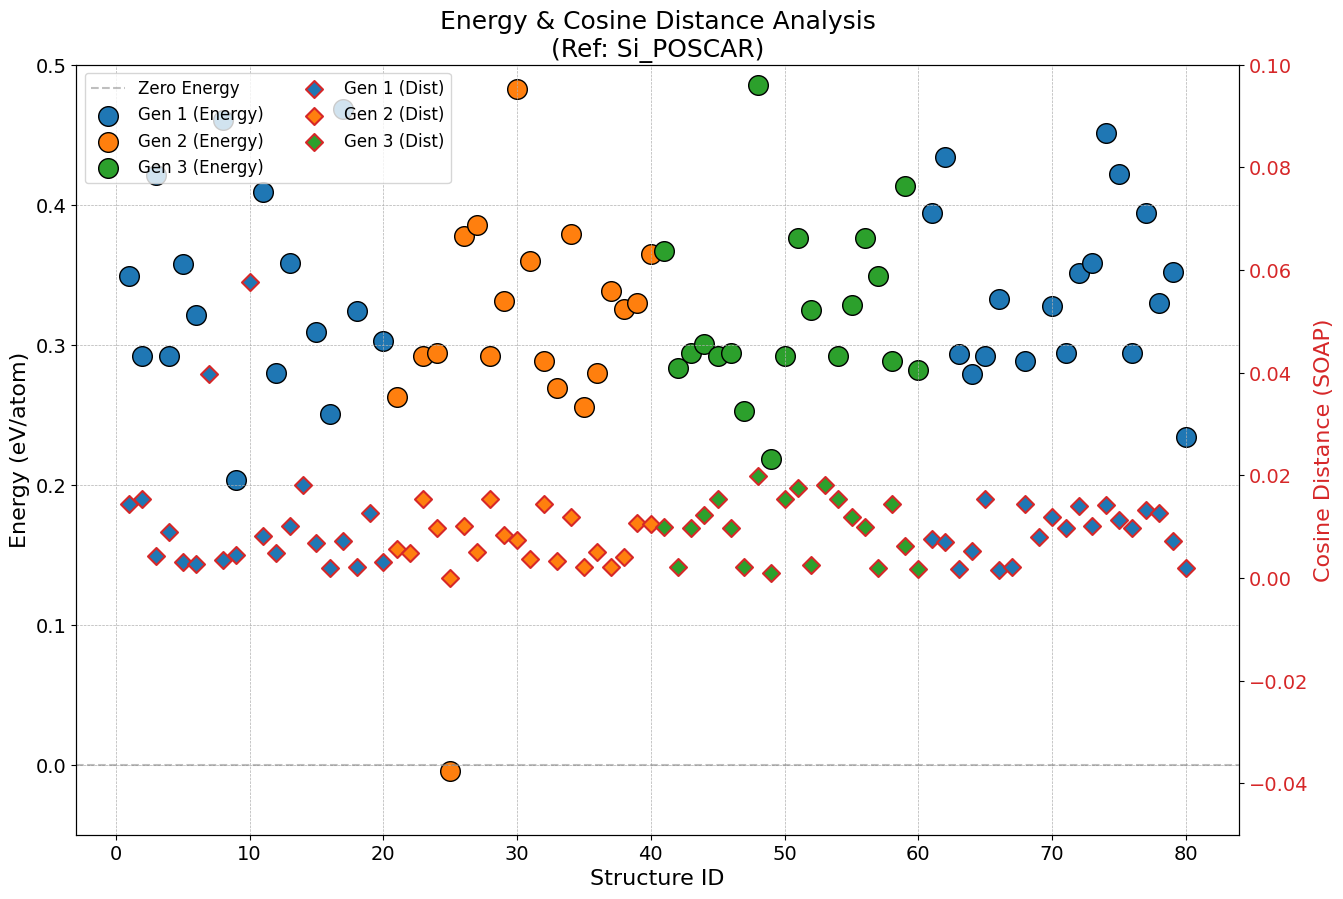

Graph saved to: ./16 atoms calculation/plot/energy_distance_graph_custom.png
Data table saved to: ./16 atoms calculation/plot/structure_analysis_data.txt


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from ase import io
from scipy.spatial.distance import cosine
from dscribe.descriptors import SOAP
from mattersim.forcefield import MatterSimCalculator

# ==========================================
#        USER DEFINED VARIABLES
# ==========================================

# --- Paths ---
INPUT_DIR = "./16 atoms calculation/plot"
OUTPUT_DIR = "./16 atoms calculation/plot"
STANDARD_FILE = "./standard_/Si_POSCAR"

# --- Y-Axis Scale Settings (ADJUST HERE) ---
# 1. Energy Axis (Left)
ENERGY_MIN = -0.05
ENERGY_MAX = 0.5

# 2. Cosine Distance Axis (Right)
DIST_MIN = -0.05
DIST_MAX = 0.1

# 3. Alignment Switch
# True  = Automatically calculate DIST_MIN to force 0-energy and 0-distance to align.
# False = Use your manual DIST_MIN and DIST_MAX values exactly.
SYNC_ZERO_LINES = False   # <--- Change to True if you want them aligned

# --- Energy Calculation Settings ---
ENERGY_SHIFT = 5.410

# --- SOAP Settings ---
SOAP_R_CUT = 6.0
SOAP_N_MAX = 4
SOAP_L_MAX = 4
SOAP_SIGMA = 0.5

# ==========================================

def get_soap_descriptor(atoms_list, r_cut, n_max, l_max, sigma):
    species = set()
    for atoms in atoms_list:
        species.update(atoms.get_chemical_symbols())
    
    return SOAP(
        species=sorted(list(species)),
        periodic=True,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
        sigma=sigma,
        average='inner'
    )

def process_structures():
    # 1. Setup Output Directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    # 2. Load Standard Structure
    print(f"Loading standard structure from: {STANDARD_FILE}")
    try:
        standard_atoms = io.read(STANDARD_FILE)
    except FileNotFoundError:
        print(f"Error: Standard file not found at {STANDARD_FILE}")
        return

    # 3. Initialize SOAP
    soap = get_soap_descriptor(
        [standard_atoms], 
        SOAP_R_CUT, 
        SOAP_N_MAX, 
        SOAP_L_MAX, 
        SOAP_SIGMA
    )
    
    std_vector = soap.create(standard_atoms).flatten()
    print("SOAP descriptor initialized and standard vector calculated.")

    # 4. Scan Files
    search_path = os.path.join(INPUT_DIR, "*_POSCAR*")
    all_files = sorted(glob.glob(search_path))
    
    structure_data = [] 
    count = 1

    print(f"Scanning {INPUT_DIR} for *_POSCAR files...")

    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        if os.path.abspath(file_path) == os.path.abspath(STANDARD_FILE):
            continue
            
        if os.path.isdir(file_path):
            continue

        try:
            atoms = io.read(file_path)
            
            # --- Energy Calculation ---
            atoms.calc = MatterSimCalculator()
            total_energy = atoms.get_potential_energy()
            num_atoms = len(atoms)
            
            raw_energy_per_atom = total_energy / num_atoms
            energy_per_atom = raw_energy_per_atom + ENERGY_SHIFT
            
            # --- Cosine Distance Calculation ---
            target_vector = soap.create(atoms).flatten()
            cos_dist = cosine(std_vector, target_vector)

            # --- Group Logic ---
            group_id = 1
            if 1 <= count <= 20:
                group_id = 1 
            elif 21 <= count <= 40:
                group_id = 2 
            elif 41 <= count <= 60:
                group_id = 3 
            
            structure_data.append({
                "id": count,
                "filename": filename,
                "energy_per_atom": energy_per_atom,
                "cosine_distance": cos_dist,
                "group_id": group_id
            })
            
            print(f"ID {count}: {filename} | E: {energy_per_atom:.4f} eV | Dist: {cos_dist:.4f}")
            count += 1
            
        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    if not structure_data:
        print("No valid structures found.")
        return

    plot_data = [d for d in structure_data if d['group_id'] in (1, 2, 3)]
    
    if not plot_data:
        print("No structures found in range 1-60.")
        return

    # 5. Generate and Save Plot (Dual Axis)
    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green'}
    labels = {1: 'Gen 1', 2: 'Gen 2', 3: 'Gen 3'}

    # --- Plot Energy (Left Axis) ---
    ax1.set_xlabel('Structure ID', fontsize=16)
    ax1.set_ylabel('Energy (eV/atom)', fontsize=16, color='black')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    
    # Set Energy Limits
    ax1.set_ylim(ENERGY_MIN, ENERGY_MAX)
    
    # Reference Line for Energy Zero
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero Energy')

    # --- Plot Cosine Distance (Right Axis) ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cosine Distance (SOAP)', fontsize=16, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

    # --- AXIS LIMITS LOGIC ---
    if SYNC_ZERO_LINES:
        # Auto-calculate DIST_MIN to align zeros
        d_target_max = DIST_MAX
        
        if ENERGY_MAX > ENERGY_MIN:
            zero_fraction_e = (0 - ENERGY_MIN) / (ENERGY_MAX - ENERGY_MIN)
        else:
            zero_fraction_e = 0.0

        if 0 <= zero_fraction_e < 1:
            d_axis_min = (zero_fraction_e * d_target_max) / (zero_fraction_e - 1)
        elif zero_fraction_e == 1:
            d_axis_min = DIST_MIN
            d_target_max = 0.0
        else:
            d_axis_min = DIST_MIN # Fallback
            
        ax2.set_ylim(d_axis_min, d_target_max)
    else:
        # Use Manual Limits
        ax2.set_ylim(DIST_MIN, DIST_MAX)
    # -------------------------

    # Loop to plot points
    for gid in [1, 2, 3]:
        group_items = [d for d in plot_data if d['group_id'] == gid]
        if not group_items:
            continue
            
        ids = [d['id'] for d in group_items]
        energies = [d['energy_per_atom'] for d in group_items]
        distances = [d['cosine_distance'] for d in group_items]
        
        ax1.scatter(ids, energies, s=200, color=colors[gid], edgecolors='black', 
                    marker='o', label=f'{labels[gid]} (Energy)')
        
        ax2.scatter(ids, distances, s=75, color=colors[gid], edgecolors='tab:red', 
                    marker='D', linewidth=1.5, label=f'{labels[gid]} (Dist)')

    ax1.set_title(f'Energy & Cosine Distance Analysis\n(Ref: {os.path.basename(STANDARD_FILE)})', fontsize=18)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12, ncol=2)
    
    graph_path = os.path.join(OUTPUT_DIR, 'energy_distance_graph_custom.png')
    plt.savefig(graph_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Graph saved to: {graph_path}")

    # 6. Save Data to Text File
    txt_path = os.path.join(OUTPUT_DIR, 'structure_analysis_data.txt')
    with open(txt_path, 'w') as f:
        header = f"{'ID':<5} {'Group':<7} {'Filename':<30} {'Energy (eV/atom)':<20} {'Cos Distance':<20}\n"
        f.write(header)
        f.write("-" * len(header) + "\n")
        for data in structure_data:
            line = (f"{data['id']:<5} {data['group_id']:<7} {data['filename']:<30} "
                    f"{data['energy_per_atom']:<20.6f} {data['cosine_distance']:<20.6f}\n")
            f.write(line)
            
    print(f"Data table saved to: {txt_path}")

if __name__ == "__main__":
    process_structures()

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from ase import io
from scipy.spatial.distance import cosine
from dscribe.descriptors import SOAP
from mattersim.forcefield import MatterSimCalculator

# ==========================================
#        USER DEFINED VARIABLES
# ==========================================

# --- Paths ---
INPUT_DIR = "./16 atoms calculation/plot"
OUTPUT_DIR = "./16 atoms calculation/plot"
STANDARD_FILE = "./standard_/Si_POSCAR"

# --- Axis Scale Settings (ADJUST HERE) ---
# 1. Energy Axis (Y-Axis)
ENERGY_MIN = -0.05
ENERGY_MAX = 0.5

# 2. Cosine Similarity Axis (X-Axis)
# Similarity is usually between 0 and 1 (1.0 = identical)
SIM_MIN = 0.80
SIM_MAX = 1.02

# --- Energy Calculation Settings ---
ENERGY_SHIFT = 5.410

# --- SOAP Settings ---
SOAP_R_CUT = 6.0
SOAP_N_MAX = 4
SOAP_L_MAX = 4
SOAP_SIGMA = 0.5

# ==========================================

def get_soap_descriptor(atoms_list, r_cut, n_max, l_max, sigma):
    species = set()
    for atoms in atoms_list:
        species.update(atoms.get_chemical_symbols())
    
    return SOAP(
        species=sorted(list(species)),
        periodic=True,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
        sigma=sigma,
        average='inner'
    )

def process_structures():
    # 1. Setup Output Directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    # 2. Load Standard Structure
    print(f"Loading standard structure from: {STANDARD_FILE}")
    try:
        standard_atoms = io.read(STANDARD_FILE)
    except FileNotFoundError:
        print(f"Error: Standard file not found at {STANDARD_FILE}")
        return

    # 3. Initialize SOAP
    soap = get_soap_descriptor(
        [standard_atoms], 
        SOAP_R_CUT, 
        SOAP_N_MAX, 
        SOAP_L_MAX, 
        SOAP_SIGMA
    )
    
    std_vector = soap.create(standard_atoms).flatten()
    print("SOAP descriptor initialized and standard vector calculated.")

    # 4. Scan Files
    search_path = os.path.join(INPUT_DIR, "*_POSCAR*")
    all_files = sorted(glob.glob(search_path))
    
    structure_data = [] 
    count = 1

    print(f"\nScanning {INPUT_DIR} for *_POSCAR files...")
    print(f"{'No.':<5} {'Filename':<35} {'Energy':<15} {'Similarity'}")
    print("-" * 70)

    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        if os.path.abspath(file_path) == os.path.abspath(STANDARD_FILE):
            continue
            
        if os.path.isdir(file_path):
            continue

        try:
            atoms = io.read(file_path)
            
            # --- Energy Calculation ---
            atoms.calc = MatterSimCalculator()
            total_energy = atoms.get_potential_energy()
            num_atoms = len(atoms)
            
            raw_energy_per_atom = total_energy / num_atoms
            energy_per_atom = raw_energy_per_atom + ENERGY_SHIFT
            
            # --- Cosine Similarity Calculation ---
            target_vector = soap.create(atoms).flatten()
            # Similarity = 1 - Distance
            cos_sim = 1 - cosine(std_vector, target_vector)

            # --- Group Logic ---
            group_id = 1
            if 1 <= count <= 20:
                group_id = 1 
            elif 21 <= count <= 40:
                group_id = 2 
            elif 41 <= count <= 60:
                group_id = 3 
            
            structure_data.append({
                "id": count,
                "filename": filename,
                "energy_per_atom": energy_per_atom,
                "cosine_similarity": cos_sim,
                "group_id": group_id
            })
            
            # Print to Output Console
            print(f"{count:<5} {filename:<35} {energy_per_atom:.4f} eV      {cos_sim:.4f}")
            count += 1
            
        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    if not structure_data:
        print("No valid structures found.")
        return

    plot_data = [d for d in structure_data if d['group_id'] in (1, 2, 3)]
    
    if not plot_data:
        print("No structures found in range 1-60.")
        return

    # 5. Generate and Save Plot (Single Marker Scatter)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green'}
    labels = {1: 'Gen 1', 2: 'Gen 2', 3: 'Gen 3'}

    # Loop to plot points
    for gid in [1, 2, 3]:
        group_items = [d for d in plot_data if d['group_id'] == gid]
        if not group_items:
            continue
            
        # Extract X (Similarity) and Y (Energy)
        energies = [d['energy_per_atom'] for d in group_items]
        similarities = [d['cosine_similarity'] for d in group_items]
        
        # Plot single marker for each structure
        ax.scatter(similarities, energies, s=150, color=colors[gid], edgecolors='black', 
                   marker='o', label=labels[gid], alpha=0.8)

    # Labels and Limits
    ax.set_xlabel('Cosine Similarity (SOAP)', fontsize=16)
    ax.set_ylabel('Energy (eV/atom)', fontsize=16)
    
    ax.set_xlim(SIM_MIN, SIM_MAX)
    ax.set_ylim(ENERGY_MIN, ENERGY_MAX)
    
    # Reference Lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero Energy')
    ax.axvline(x=1.0, color='red', linestyle=':', alpha=0.5, label='Identical (1.0)')

    ax.set_title(f'Structure Map: Energy vs Similarity\n(Ref: {os.path.basename(STANDARD_FILE)})', fontsize=18)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=12, loc='upper left')
    
    graph_path = os.path.join(OUTPUT_DIR, 'energy_vs_similarity.png')
    plt.savefig(graph_path, dpi=300)
    plt.show()
    plt.close()
    print(f"\nGraph saved to: {graph_path}")

    # 6. Save Data to Text File
    txt_path = os.path.join(OUTPUT_DIR, 'structure_analysis_data.txt')
    with open(txt_path, 'w') as f:
        header = f"{'ID':<5} {'Group':<7} {'Filename':<30} {'Energy (eV/atom)':<20} {'Similarity':<20}\n"
        f.write(header)
        f.write("-" * len(header) + "\n")
        for data in structure_data:
            line = (f"{data['id']:<5} {data['group_id']:<7} {data['filename']:<30} "
                    f"{data['energy_per_atom']:<20.6f} {data['cosine_similarity']:<20.6f}\n")
            f.write(line)
            
    print(f"Data table saved to: {txt_path}")

if __name__ == "__main__":
    process_structures()